# Load Libraries

In [348]:
suppressPackageStartupMessages({
    library(MASS)
    library(gdata)
    library(singlecellmethods)
    library(matrixStats)
    library(data.table)
    library(viridis)
    library(RColorBrewer)
    library(pheatmap)
    library(Matrix)
    library(harmony)
    library(uwot)
    library(irlba)
    library(Seurat)
    library(factoextra)
    library(presto) 
    source("2023-08-03 RPL8-IL2RA-CTLA4-TCR-Primer-HET/utils.R")
    source("2023-08-03 RPL8-IL2RA-CTLA4-TCR-Primer-HET/misc_funcs.R")
    library(tidyverse)
    library(Biostrings)
    library(ggpubr)
    library(ggridges)
    library(ggrepel)
    library(lme4)
})



# Import

In [393]:
Run1exprs <- readMM("2023-08-03 RPL8-IL2RA-CTLA4-TCR-Primer-HET/filt_exprs_rna.mtx")
colnames(Run1exprs) <- read.csv("2023-08-03 RPL8-IL2RA-CTLA4-TCR-Primer-HET/filt_colnames_exprs_rna.csv")[,2]
rownames(Run1exprs) <- read.csv("2023-08-03 RPL8-IL2RA-CTLA4-TCR-Primer-HET/filt_rownames_exprs_rna.csv")[,2]

Run1counts_adt <- readMM("2023-08-03 RPL8-IL2RA-CTLA4-TCR-Primer-HET/exprs_adt.mtx")
colnames(Run1counts_adt) <- read.csv("2023-08-03 RPL8-IL2RA-CTLA4-TCR-Primer-HET/colnames_exprs_adt.csv")[,2]
rownames(Run1counts_adt) <- read.csv("2023-08-03 RPL8-IL2RA-CTLA4-TCR-Primer-HET/rownames_exprs_adt.csv")[,2]

Run2exprs <- readMM("2023-05-11 CIITA-TBET-FOXP3-IL2RA-BACH2/exprs.mtx")
colnames(Run2exprs) <- read.csv("2023-05-11 CIITA-TBET-FOXP3-IL2RA-BACH2/exprs_colnames.csv")[,2]
rownames(Run2exprs) <- read.csv("2023-05-11 CIITA-TBET-FOXP3-IL2RA-BACH2/exprs_rownames.csv")[,2]

Run2counts_adt <- readMM("2023-05-11 CIITA-TBET-FOXP3-IL2RA-BACH2/counts_ADT_filt.mtx")
colnames(Run2counts_adt) <- read.csv("2023-05-11 CIITA-TBET-FOXP3-IL2RA-BACH2/colnames_counts_ADT_filt.csv")[,2]
rownames(Run2counts_adt) <- read.csv("2023-05-11 CIITA-TBET-FOXP3-IL2RA-BACH2/rownames_counts_ADT_filt.csv")[,2]



In [394]:
Run2meta <- read.csv("2023-05-11 CIITA-TBET-FOXP3-IL2RA-BACH2/Run2meta_updated.csv")

Run1meta <- read.csv("2023-08-03 RPL8-IL2RA-CTLA4-TCR-Primer-HET/Run1meta_updated.csv")

In [395]:
norm_Run1exprs<-  normalizeData(Run1exprs, method = "log")
norm_Run2exprs <- normalizeData(Run2exprs, method = "log")

In [396]:
norm_Run1adt<-  normalizeData(Run1counts_adt, method = "cellCLR")
norm_Run2adt <- normalizeData(Run2counts_adt, method = "cellCLR")

In [397]:
Run1meta$Run <- 1
Run2meta$Run <- 2
Run1meta <- mutate(Run1meta, plate = paste0(Run, DNA_Barcode))
Run2meta <- mutate(Run2meta, plate = paste0(Run, DNA_Barcode))

In [398]:
Run1meta <- dplyr::rename(Run1meta, CRISPR_Index = IL2RA_Control)

In [399]:
Run2meta <- dplyr::rename(Run2meta, CRISPR_Index = Edited_Index)

In [387]:
QC <- Run2counts_adt %>% colnames %>% str_split(pattern = "_",simplify = T)
QC %>% as.tibble %>% filter(V2 %in%  Run2meta$RNA_Barcode) %>% with(V2) %>% table

.
ACTCTTCCTT ATTAGTGGAG TAAGACCTAT TGCTAACTAT TGGTTAAGAA 
       249        258        251        258        281 

In [389]:
read_csv("2023-08-03 RPL8-IL2RA-CTLA4-TCR-Primer-HET/filt_meta_adt.csv")%>% filter(Condition == "IL2RA") %>% with(plate) %>% table

New names:
• `` -> `...1`
Rows: 4743 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (12): ...1, plate, cell_adt, PlateLabel, Condition, RNA_Barcode, DNA_Bar...
dbl  (2): nUMI, nGenes

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


.
CAACGTCAGC CGCGCCTAGA CGGTTATTAG GATACCTCCT TCTTGGCTAT 
       313        323        327        290        326 

# QC

In [400]:
Run1exprs <- Run1exprs[,Run1meta$cell]
Run2exprs <- Run2exprs[,Run2meta$cell]

In [401]:
Run1counts_adt <- Run1counts_adt[,Run1meta$cell]
Run2counts_adt <- Run2counts_adt[,Run2meta$cell]

## RNA QC

In [402]:
nUMI = colSums(Run1exprs)
nGenes = colSums(Run1exprs > 0)
pctMito = colSums(Run1exprs[rownames(Run1exprs)[rownames(Run1exprs) %>% startsWith('MT-')], ])/nUMI
qc_df = data.frame(nUMI = nUMI, nGenes = nGenes, pctMito = pctMito)

# meta = cbind(meta, qc_df[rownames(meta), ])
nCells = rowSums(Run1exprs > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

In [403]:
Run1exprs <- Run1exprs[nCells > 0.1 *dim(Run1exprs)[2],]

In [404]:
# meta = cbind(meta, qc_df[rownames(meta), ])
nCells = rowSums(Run2exprs > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

In [405]:
Run2exprs <- Run2exprs[nCells > 0.1 *dim(Run2exprs)[2],]

# Pre-process expression data

In [406]:
#Merge two matrices
sharedgenes <- rownames(Run1exprs) %>% intersect(rownames(Run2exprs))
colnames(Run1exprs) <- paste0("1_", colnames(Run1exprs))
colnames(Run2exprs) <- paste0("2_", colnames(Run2exprs))

#Bind together
full_exprs <- cbind(Run1exprs[sharedgenes,], Run2exprs[sharedgenes,])

In [407]:
#Fix meta
Run1meta <- mutate(Run1meta, cell = paste0("1_", cell))
#fix meta
Run2meta <- mutate(Run2meta, cell = paste0("2_", cell))

In [409]:
#fix naminmg
Run1meta <- select(Run1meta, -nGenes.y) %>% dplyr::rename(nGenes = nGenes.x)

In [410]:
#Master meta file
full_meta <- 
rbind( 
    Run1meta %>% select(cell, AllelicGenotype, Dosage, Run, Polarization_Index, Individual_Index, nUMI, nGenes, plate, nUMI_ADT),
    Run2meta %>% select(cell, AllelicGenotype, Dosage, Run, Polarization_Index, Individual_Index, nUMI, nGenes, plate, nUMI_ADT)
    )

In [411]:
#Remove error and nas 
full_meta$Individual_Index %>% table
full_meta <- filter(full_meta, !(Individual_Index %in% c("Error", "10038188")))
full_meta %>% dim
full_meta <- na.omit(full_meta)
full_meta %>% dim

.
10018115 10018649 10023241 10028616 10038188 10048363 
     255      269      576      712       54      255 

[1] 2067   10

[1] 2067   10

In [412]:
full_meta$Dosage %>% table

.
  0   1   2 
877 767 423 

In [413]:
#fix rownames
rownames(full_meta) <- full_meta$cell

# Preprocess ADT data

In [414]:
#Merge two matrices
sharedadt <- rownames(Run1counts_adt) %>% intersect(rownames(Run2counts_adt))
colnames(Run1counts_adt) <- paste0("1_", colnames(Run1counts_adt))
colnames(Run2counts_adt) <- paste0("2_", colnames(Run2counts_adt))

#Bind together
full_adt <- cbind(Run1counts_adt[sharedadt,], Run2counts_adt[sharedadt,])

In [415]:
scale_adt <- process_adt(full_adt, full_meta)

# UMAPs

In [416]:
rownames(full_meta) <- full_meta$cell

In [466]:
scale_exprs = process_rna(full_exprs, full_meta, topn = 3000)

In [467]:
set.seed(seed = 100)
full_meta$Run <- as.factor(full_meta$Run)

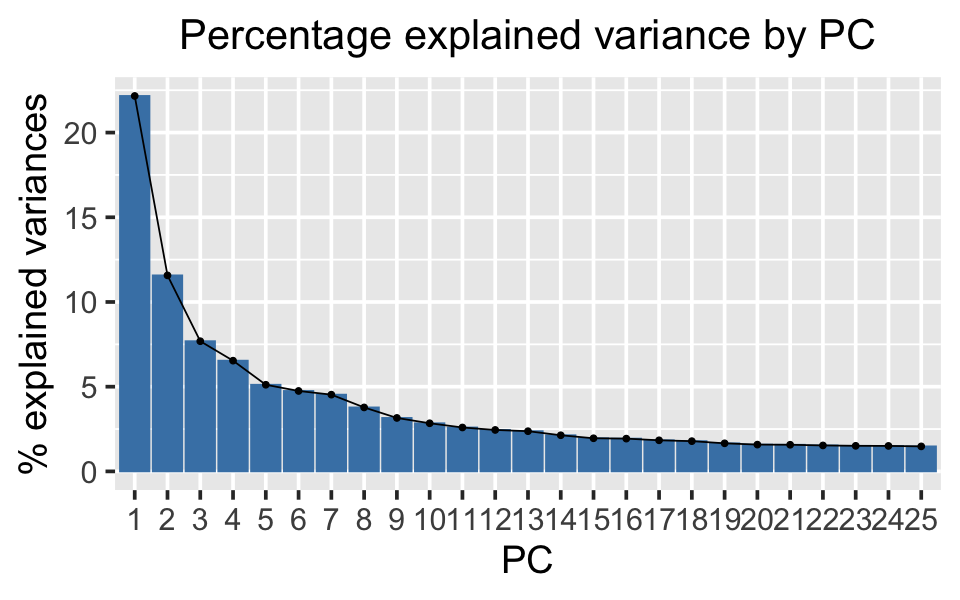

In [468]:
pca_res = prcomp_irlba(scale_exprs %>% t, 25)
rownames(pca_res$x) = colnames(scale_exprs)
rownames(pca_res$rotation) = rownames(scale_exprs)
pcs = pca_res$x
fig.size(5, 8)
p = fviz_screeplot(pca_res, ncp = 25) + theme_g() + ggtitle("Percentage explained variance by PC") + 
        xlab("PC") + ylab("% explained variances")
print(p)
    

Warning message:
“HarmonyMatrix is deprecated and will be removed in the future from the API in the future”
Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



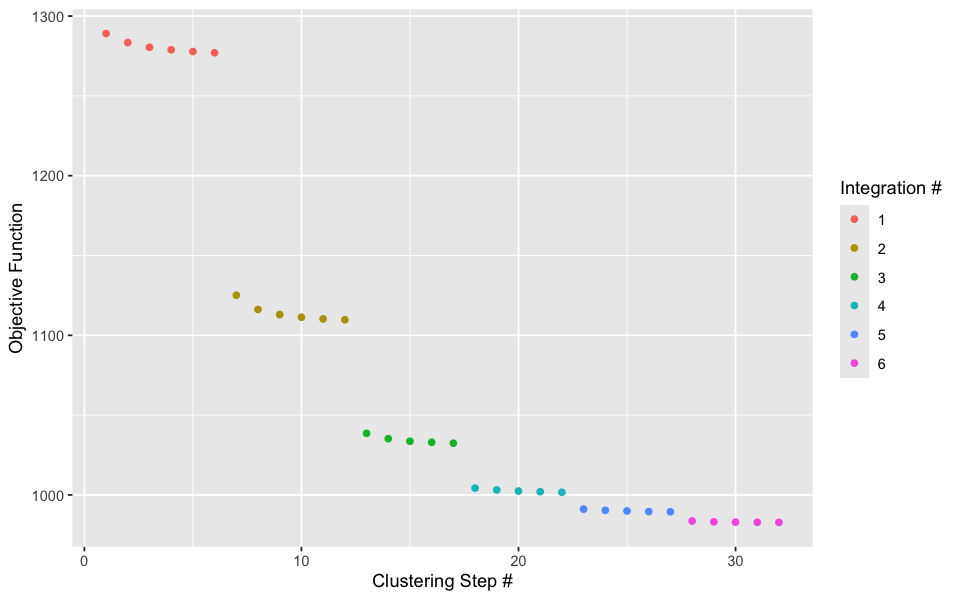

In [469]:
umap_input <- HarmonyMatrix(pcs[, 1:10], full_meta[rownames(pcs),], 
            c("plate", "Run"), 
            plot_convergence = TRUE, max.iter.harmony = 10, epsilon.cluster = -Inf, 
            epsilon.harmony = -Inf, max.iter.cluster = 10, do_pca = F, 
            verbose = F)
umap_res = umap(umap_input)
umap_df = data.frame(umap_res)
colnames(umap_df) = c("UMAP1", "UMAP2")
meta_umap = cbind(full_meta[rownames(umap_df), ], umap_df, umap_input[rownames(umap_df), 
        ])

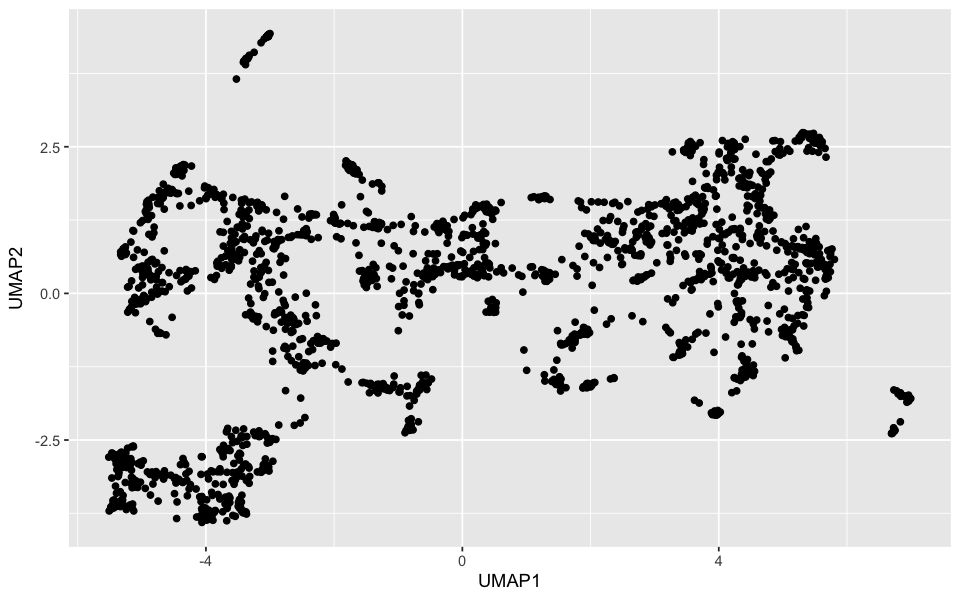

In [470]:
meta_umap %>% ggplot(aes(UMAP1, UMAP2)) + geom_point()

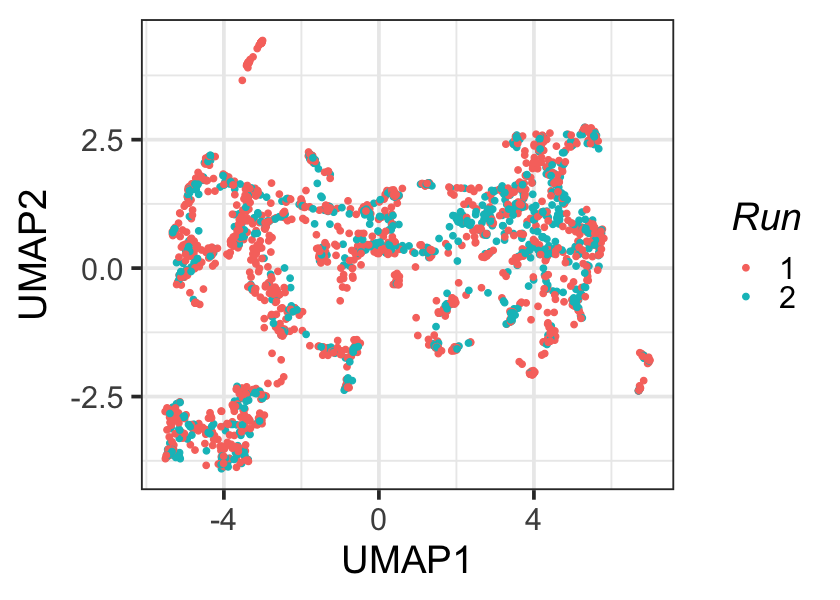

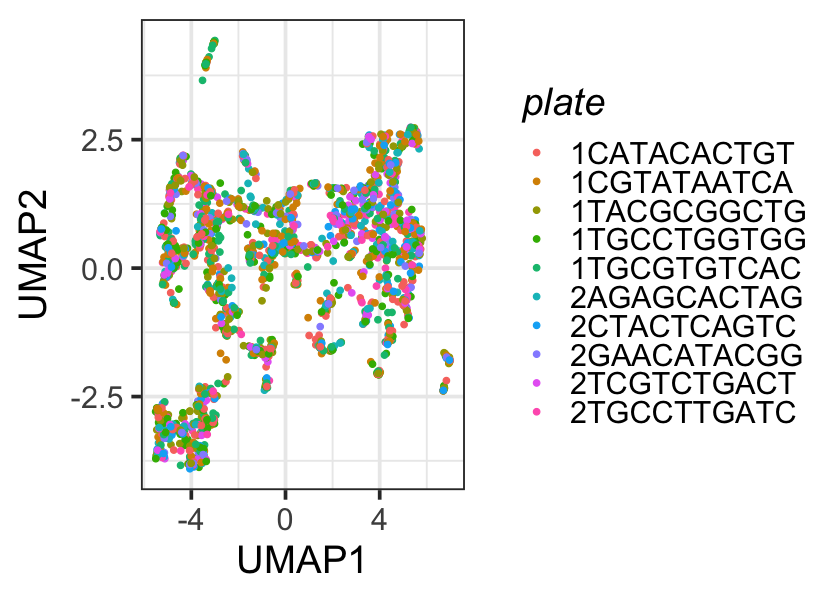

In [471]:
fig.size(5, 7)
ggplot(meta_umap %>% sample_n(nrow(meta_umap)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = Run))+
    theme_gy()

fig.size(5, 7)
ggplot(meta_umap %>% sample_n(nrow(meta_umap)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = plate))+
    theme_gy()

In [426]:
meta_umap %>% write_csv("meta_umap_IL2RAjoint.csv")

# Clustering + DGE

In [300]:
meta_umap <- read_csv("meta_umap_IL2RAjoint.csv")

Rows: 2067 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): cell, AllelicGenotype, Polarization_Index, plate
dbl (18): Dosage, Run, Individual_Index, nUMI, nGenes, nUMI_ADT, UMAP1, UMAP...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [475]:
rownames(meta_umap) <- meta_umap$cell

In [477]:
meta_umap <- meta_umap %>% as.data.frame
rownames(meta_umap) <- meta_umap$cell

In [478]:
meta_umap.clust = do_cluster(meta_umap, resolution_list = seq(0.05, 0.5, 0.05))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2067
Number of edges: 65606

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9502
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2067
Number of edges: 65606

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9147
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2067
Number of edges: 65606

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8921
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2067
Number of edges: 65606

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8730
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer ver

In [479]:
meta_umap.clust$`res.0.1` %>% table

.
   0    1    2 
1110  912   45 

In [480]:
meta_umap.clust$cluster = meta_umap.clust$`res.0.1`

Joining with `by = join_by(cell)`


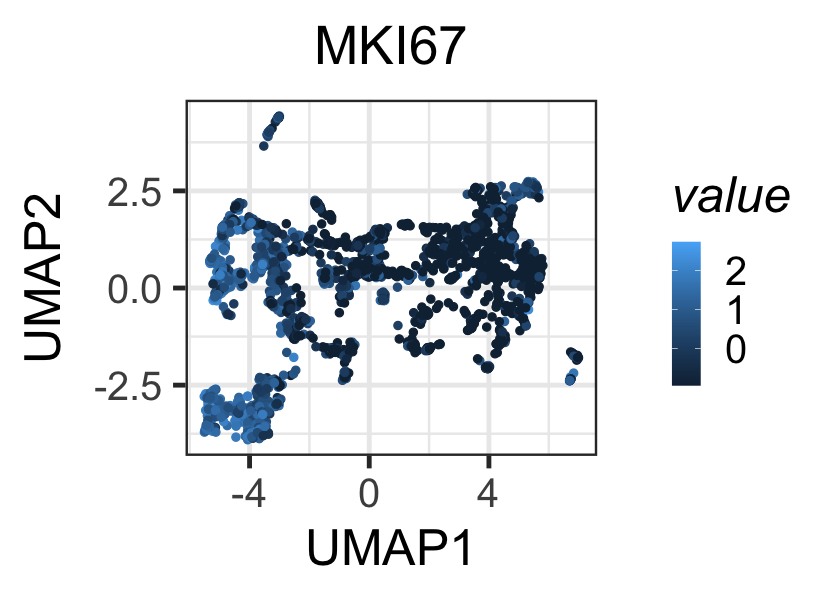

In [512]:
fig.size(5, 7)
scale_exprs["MKI67", ] %>% as_tibble(rownames = "cell") %>% inner_join(meta_umap.clust) %>%

ggplot() + 
    geom_point(aes(x= UMAP1, y = UMAP2, col = value), size = 2)+
    theme_g(30) + theme_gy(30) + theme(legend.position = "right") + ggtitle("MKI67")


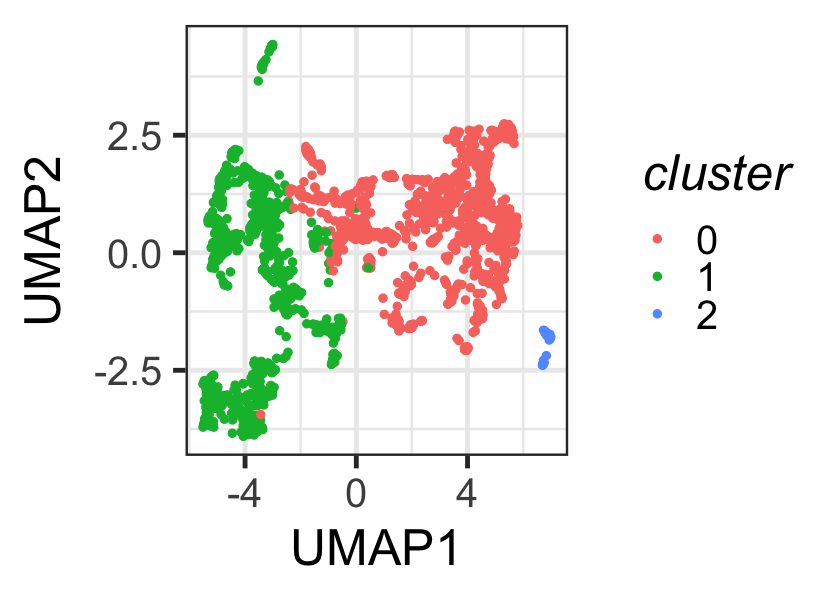

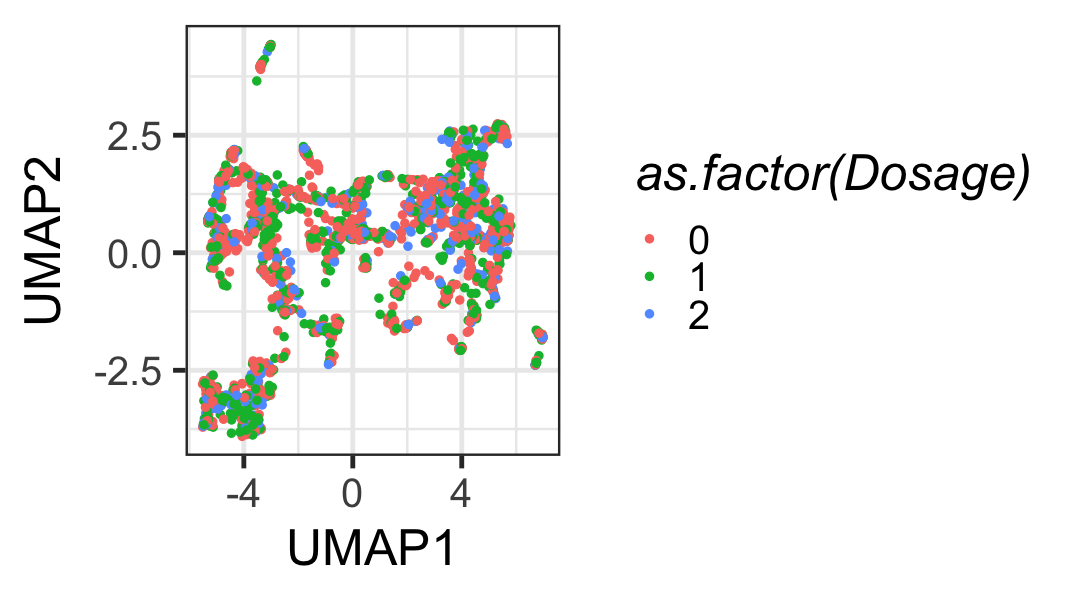

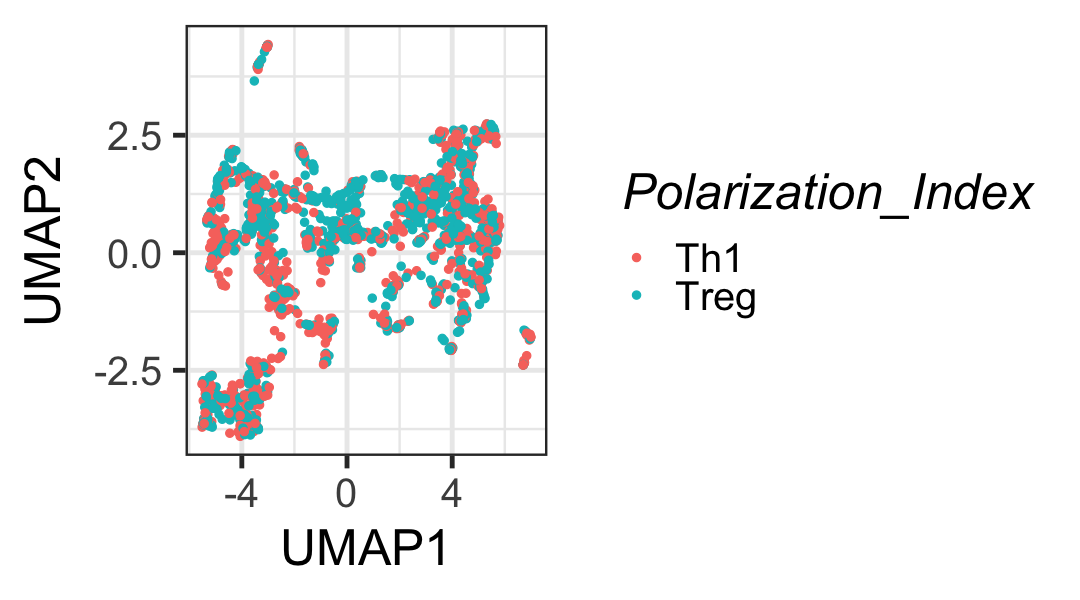

In [515]:
fig.size(5, 7)
ggplot(meta_umap.clust[sample(rownames(meta_umap.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_gy(30) 

fig.size(5, 9)
ggplot(meta_umap.clust[sample(rownames(meta_umap.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = as.factor(Dosage)), size = 2)+
    theme_gy(30) 

fig.size(5, 9)
ggplot(meta_umap.clust[sample(rownames(meta_umap.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = Polarization_Index), size = 2)+
    theme_gy(30) 

In [490]:
df<-meta_umap.clust %>% arrange(cluster)
matrix <- scale_exprs[,df$cell]

dge_CD45 = wilcoxauc(matrix, df$cluster)
var_genes_CD45 = top_markers(dge_CD45, 10) %>% head(10) %>% select(-rank) %>% 
                        unlist %>% unique 
cmax = abs(matrix[var_genes_CD45,]) %>% unlist %>% max #%>% quantile(.995)

# Data frame with column annotations.
mat_col <- data.frame(cluster = df$cluster)
rownames(mat_col) <- rownames(df)


# Sort dendogram
mat_cluster_cols <- hclust(dist(t(matrix[var_genes_CD45, ])))
mat_cluster_cols <- sort_hclust(mat_cluster_cols)
mat_cluster_rows <- sort_hclust(hclust(dist(matrix[var_genes_CD45, ])))

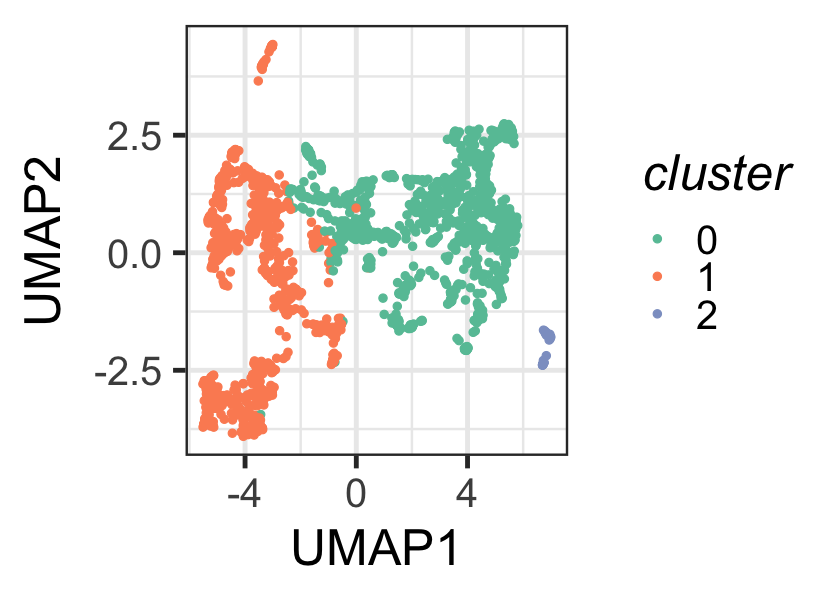

In [505]:
fig.size(5, 7)
ggplot(meta_umap.clust[sample(rownames(meta_umap.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_g(30) + theme_gy(30) + 
scale_color_manual(values = c(`0` = "#66C2A5", 
                               `1` = "#FC8D62",
                                  `2` = "#8DA0CB"
                                     ))


Joining with `by = join_by(cell)`


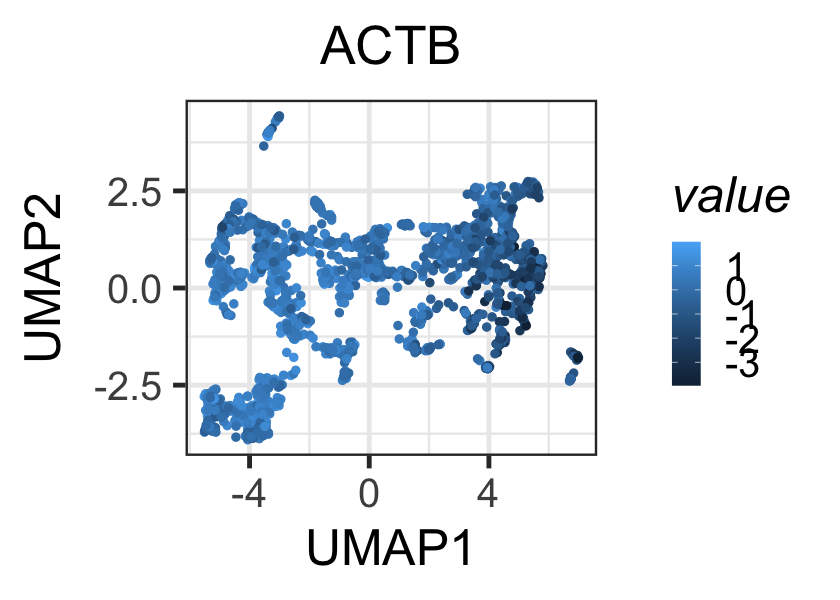

In [511]:
fig.size(5, 7)
scale_exprs["ACTB", ] %>% as_tibble(rownames = "cell") %>% inner_join(meta_umap.clust) %>%

ggplot() + 
    geom_point(aes(x= UMAP1, y = UMAP2, col = value), size = 2)+
    theme_gy(30) + theme(legend.position = "right") + ggtitle("ACTB")


In [493]:
var_genes_CD45

[1] "GAS5"       "BTG1"       "HILPDA"     "RGCC"       "JAML"      
 [6] "MALAT1"     "ADM"        "SYTL3"      "ANKRD37"    "LBH"       
[11] "TUBA1B"     "H2AFZ"      "HMGB2"      "MKI67"      "CFL1"      
[16] "TUBB"       "RRM2"       "TUBB4B"     "STMN1"      "ACTB"      
[21] "DHFR"       "MT-CO1"     "ZNF292"     "MT-ND1"     "AL590550.1"
[26] "MT-CO2"     "FP236383.3" "MNS1"       "ANKRD11"

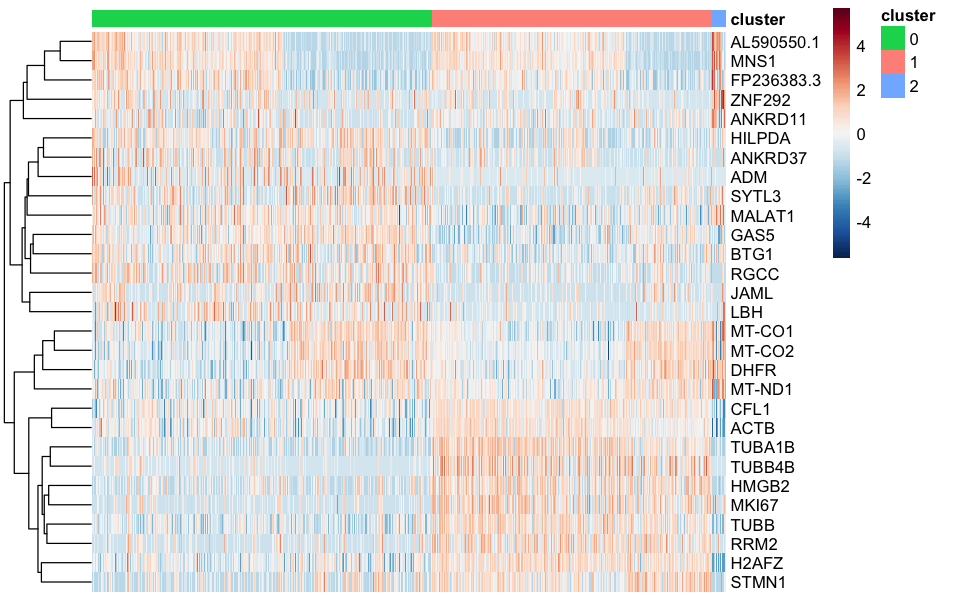

In [494]:
fig.size(5, 8)
g <- pheatmap(as.matrix(matrix[c(var_genes_CD45), df$cell]),
         breaks = seq(-cmax, cmax, length.out = 100),
        color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev,
        show_colnames = FALSE,
         annotation_col = mat_col, 
         fontsize = 10,
         cluster_cols = F,
         #annotation_colors = list(cluster = c(
         #                         `0` = "#66C2A5", 
          #                     `1` = "#FC8D62", 
           #                       `2` = "#8DA0CB"
            #                         )),
        cluster_rows = mat_cluster_rows,

        )

In [495]:
g %>% ggsave(filename = "IL2RAHeatMap.png", device = "png")

Saving 7 x 7 in image


In [496]:
norm_adt <- normalizeData(full_adt, method = "cellCLR")

Joining with `by = join_by(cell)`


npar
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          5   
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 6   
                                                                                                                                                  AIC     
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          5666.057
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 5660.192
                                                                                                                                                  BIC     
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          5688.601
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 5687.245
                                                                                                                                                  logLik   
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          -2828.028
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) -2824.096
                                                                                                                                                  deviance
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          5656.057
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 5648.192
                                                                                                                                                  Chisq   
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                NA
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 7.864712
                                                                                                                                                  Df
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          NA
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage)  1
                                                                                                                                                  Pr(>Chisq) 
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                   NA
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.005040885

npar
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          5   
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 6   
                                                                                                                                                  AIC     
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          3605.987
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 3600.957
                                                                                                                                                  BIC     
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          3626.317
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 3625.354
                                                                                                                                                  logLik   
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          -1797.993
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) -1794.478
                                                                                                                                                  deviance
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          3595.987
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 3588.957
                                                                                                                                                  Chisq   
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                NA
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 7.029692
                                                                                                                                                  Df
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          NA
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage)  1
                                                                                                                                                  Pr(>Chisq) 
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                   NA
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.008016914

npar
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          5   
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 6   
                                                                                                                                                 AIC     
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          3729.527
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 3731.518
                                                                                                                                                 BIC     
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          3749.950
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 3756.024
                                                                                                                                                 logLik   
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          -1859.764
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) -1859.759
                                                                                                                                                 deviance
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          3719.527
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 3719.518
                                                                                                                                                 Chisq      
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                   NA
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.009618197
                                                                                                                                                 Df
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          NA
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage)  1
                                                                                                                                                 Pr(>Chisq)
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                 NA 
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.9218748

npar
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          5   
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 6   
                                                                                                                                                 AIC     
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          3799.663
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 3801.625
                                                                                                                                                 BIC     
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          3820.542
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 3826.680
                                                                                                                                                 logLik   
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          -1894.832
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) -1894.813
                                                                                                                                                 deviance
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          3789.663
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 3789.625
                                                                                                                                                 Chisq     
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                  NA
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.03785115
                                                                                                                                                 Df
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          NA
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage)  1
                                                                                                                                                 Pr(>Chisq)
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                 NA 
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.8457423

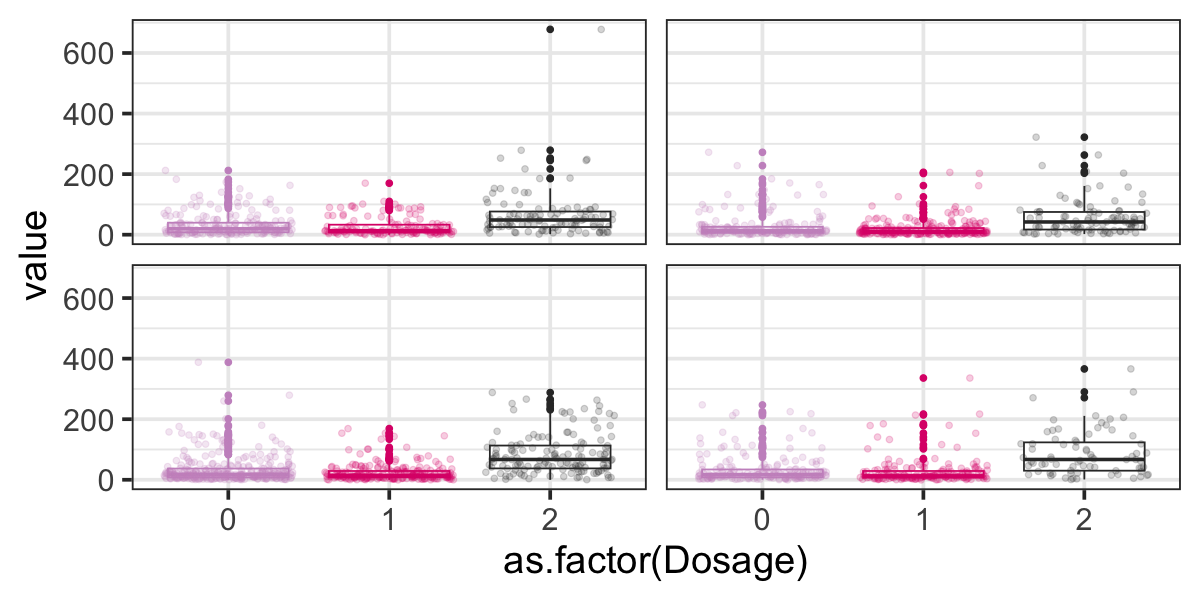

In [571]:
fig.size(5,10)
df <- full_adt["CD25", ] %>% as_tibble(rownames = "cell") %>% inner_join(meta_umap.clust) %>% na.omit()
df %>% filter(cluster != 2) %>%
ggplot(aes(as.factor(Dosage), value, color = as.factor(Dosage))) + geom_boxplot()+ geom_jitter(alpha =  0.2)+
facet_grid(Polarization_Index~cluster) + theme_gy() + 
    theme(strip.text = element_blank()) + 
scale_color_manual(values =c( 
             
                  "0" = "#C994C7",
                  "1" = "#DD1C77", 
                  "2" = "grey20")) + 
theme(legend.position = 'none')
anova(
     glmer.nb(data=filter(df, cluster == 0 & Polarization_Index == "Treg"), 
   value ~ 1+ (1|Individual_Index) + (1|plate) + log10(nUMI)),
    glmer.nb(data=filter(df, cluster == 0 & Polarization_Index == "Treg"), 
   value ~ 1+ (1|Individual_Index) + (1|plate)+ log10(nUMI) + Dosage))

 anova(
     glmer.nb(data=filter(df, cluster == 1 & Polarization_Index == "Treg"), 
   value ~ 1+ (1|Individual_Index) + (1|plate)+ log10(nUMI)),
    glmer.nb(data=filter(df, cluster == 1 & Polarization_Index == "Treg"), 
   value ~ 1+ (1|Individual_Index) + (1|plate) + log10(nUMI) + Dosage))


 anova(
     glmer.nb(data=filter(df, cluster == 0 & Polarization_Index == "Th1"), 
   value ~ 1+ (1|Individual_Index) + (1|plate) + log10(nUMI)),
    glmer.nb(data=filter(df, cluster == 0 & Polarization_Index == "Th1"), 
   value ~ 1+ (1|Individual_Index) + (1|plate)+ log10(nUMI) + Dosage))

 anova(
     glmer.nb(data=filter(df, cluster == 1 & Polarization_Index == "Th1"), 
   value ~ 1+ (1|Individual_Index) + (1|plate)+ log10(nUMI)),
    glmer.nb(data=filter(df, cluster == 1 & Polarization_Index == "Th1"), 
   value ~ 1+ (1|Individual_Index) + (1|plate) + log10(nUMI) + Dosage))
 

In [573]:
glmer.nb(data=filter(df, cluster == 0 & Polarization_Index == "Treg"), 
   value ~ 1+ (1|Individual_Index) + (1|plate) + log10(nUMI) + Dosage) %>% summary

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Negative Binomial(2.3708)  ( log )
Formula: value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) +  
    Dosage
   Data: filter(df, cluster == 0 & Polarization_Index == "Treg")

     AIC      BIC   logLik deviance df.resid 
  5660.2   5687.2  -2824.1   5648.2      665 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4906 -0.7153 -0.2275  0.5629  6.5106 

Random effects:
 Groups           Name        Variance Std.Dev.
 plate            (Intercept) 0.1601   0.4001  
 Individual_Index (Intercept) 0.2920   0.5403  
Number of obs: 671, groups:  plate, 10; Individual_Index, 5

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.00004    0.63222  -3.164  0.00156 ** 
log10(nUMI)  1.27716    0.13146   9.715  < 2e-16 ***
Dosage       0.10274    0.03647   2.817  0.00485 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Joining with `by = join_by(cell)`


npar
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          5   
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 6   
                                                                                                                                                  AIC     
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          6049.775
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 6051.233
                                                                                                                                                  BIC     
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          6072.319
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 6078.286
                                                                                                                                                  logLik   
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          -3019.888
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) -3019.617
                                                                                                                                                  deviance
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          6039.775
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 6039.233
                                                                                                                                                  Chisq    
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                 NA
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.5424285
                                                                                                                                                  Df
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          NA
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage)  1
                                                                                                                                                  Pr(>Chisq)
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                NA  
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.461428

boundary (singular) fit: see help('isSingular')


boundary (singular) fit: see help('isSingular')




npar
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          5   
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 6   
                                                                                                                                                  AIC     
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          3913.433
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 3901.228
                                                                                                                                                  BIC     
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          3933.764
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 3925.625
                                                                                                                                                  logLik   
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          -1951.717
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) -1944.614
                                                                                                                                                  deviance
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          3903.433
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 3889.228
                                                                                                                                                  Chisq   
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                NA
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 14.20531
                                                                                                                                                  Df
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          NA
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage)  1
                                                                                                                                                  Pr(>Chisq)  
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                    NA
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Treg"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.0001639074

npar
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          5   
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 6   
                                                                                                                                                 AIC     
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          3894.127
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 3896.125
                                                                                                                                                 BIC     
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          3914.549
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 3920.632
                                                                                                                                                 logLik   
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          -1942.063
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) -1942.062
                                                                                                                                                 deviance
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          3884.127
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 3884.125
                                                                                                                                                 Chisq      
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                   NA
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.002072291
                                                                                                                                                 Df
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          NA
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage)  1
                                                                                                                                                 Pr(>Chisq)
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                 NA 
glmer.nb(data = filter(df, cluster == 0 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.9636909

npar
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          5   
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 6   
                                                                                                                                                 AIC     
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          4167.547
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 4169.146
                                                                                                                                                 BIC     
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          4188.426
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 4194.202
                                                                                                                                                 logLik   
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          -2078.773
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) -2078.573
                                                                                                                                                 deviance
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          4157.547
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 4157.146
                                                                                                                                                 Chisq    
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                 NA
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.4005825
                                                                                                                                                 Df
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))          NA
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage)  1
                                                                                                                                                 Pr(>Chisq)
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI))                 NA 
glmer.nb(data = filter(df, cluster == 1 & Polarization_Index == "Th1"), value ~ 1 + (1 | Individual_Index) + (1 | plate) + log10(nUMI) + Dosage) 0.5267886

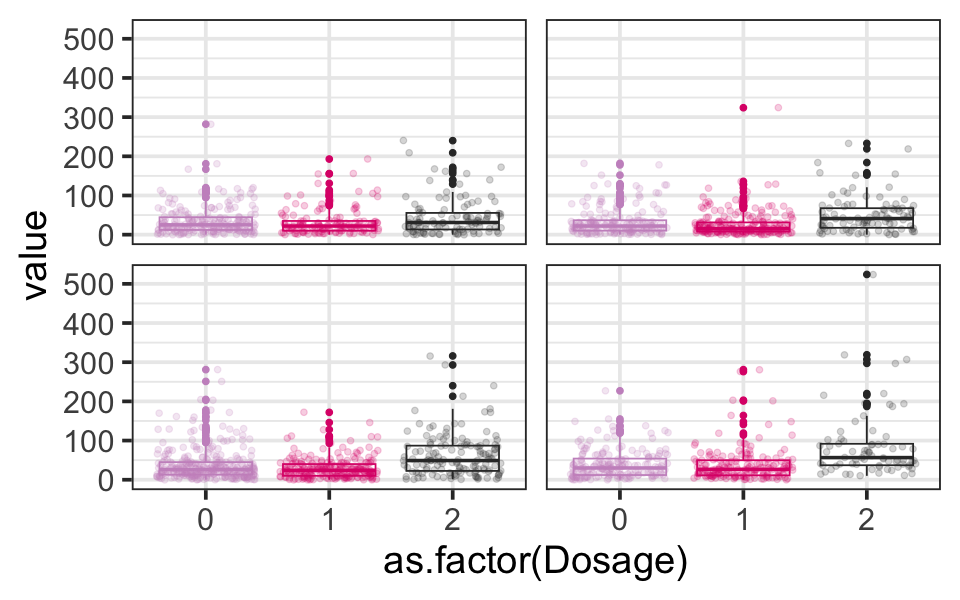

In [562]:
df <- full_exprs["IL2RA", ] %>% as_tibble(rownames = "cell") %>% inner_join(meta_umap.clust) %>% na.omit() %>% filter(cluster !=2)
df$Individual_Index<-as.factor(df$Individual_Index)
df %>% 
ggplot(aes(as.factor(Dosage), value, color = as.factor(Dosage))) + geom_boxplot()+ geom_jitter(alpha =  0.2)+
facet_grid(Polarization_Index~cluster) + theme_gy() + 
    theme(strip.text = element_blank()) + 
scale_color_manual(values =c( 
             
                  "0" = "#C994C7",
                  "1" = "#DD1C77", 
                  "2" = "grey20")) + 
theme(legend.position = 'none')
 anova(
     glmer.nb(data=filter(df, cluster == 0 & Polarization_Index == "Treg"), 
   value ~ 1+ (1|Individual_Index) + (1|plate) + log10(nUMI)),
    glmer.nb(data=filter(df, cluster == 0 & Polarization_Index == "Treg"), 
   value ~ 1+ (1|Individual_Index) + (1|plate)+ log10(nUMI) + Dosage))

 anova(
     glmer.nb(data=filter(df, cluster == 1 & Polarization_Index == "Treg"), 
   value ~ 1+ (1|Individual_Index) + (1|plate)+ log10(nUMI)),
    glmer.nb(data=filter(df, cluster == 1 & Polarization_Index == "Treg"), 
   value ~ 1+ (1|Individual_Index) + (1|plate) + log10(nUMI) + Dosage))
 
 anova(
     glmer.nb(data=filter(df, cluster == 0 & Polarization_Index == "Th1"), 
   value ~ 1+ (1|Individual_Index) + (1|plate) + log10(nUMI)),
    glmer.nb(data=filter(df, cluster == 0 & Polarization_Index == "Th1"), 
   value ~ 1+ (1|Individual_Index) + (1|plate)+ log10(nUMI) + Dosage))

 anova(
     glmer.nb(data=filter(df, cluster == 1 & Polarization_Index == "Th1"), 
   value ~ 1+ (1|Individual_Index) + (1|plate)+ log10(nUMI)),
    glmer.nb(data=filter(df, cluster == 1 & Polarization_Index == "Th1"), 
   value ~ 1+ (1|Individual_Index) + (1|plate) + log10(nUMI) + Dosage))
 

## Residual Plots

In [452]:
library(Hmisc)


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:Biostrings’:

    mask, translate


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following object is masked from ‘package:Seurat’:

    Key


The following object is masked from ‘package:SeuratObject’:

    Key


The following objects are masked from ‘package:base’:

    format.pval, units




In [539]:
ResidualsPlotADT <- function(data, gene){ 

df <- data[gene, ] %>% as_tibble(rownames = "cell") %>% inner_join(meta_umap.clust) %>% filter(cluster != 2) %>% inner_join(
dplyr::select(full_meta, cell, nUMI_ADT)) %>% na.omit()
    
df$Individual_Index <- as.factor(df$Individual_Index)

#Plotting residuals
#Linear model
ADT_regressed <- glmer.nb(data= df, 
   value ~ 1+ (1|Individual_Index) + (1|plate) + log10(nUMI_ADT))

#Pull residuals and add meta data
Residuals_ADT <- resid(ADT_regressed) %>% as_tibble() %>% 
cbind("Dosage" = df$Dosage, 
      "cluster" = df$cluster, 
      "Polarization" = df$Polarization_Index, 
      "Run" = df$Run, 
         "Individual" = df$Individual_Index, 
     "Plate" = df$plate) 

#Plot
g<- Residuals_ADT %>% 
ggplot(aes(as.factor(Dosage), value, color = as.factor(Dosage))) +
facet_grid(Polarization~cluster) +
#stat_summary(fun.data = mean_cl_normal, geom = "errorbar") +  
ylab("Regressed ADT") + 
xlab("Dosage") + theme_gy() + 
geom_boxplot(outlier.shape = NA)+
theme_gy(30) +
geom_jitter(alpha = 0.2)+ 
theme(strip.text = element_blank()) + 
scale_color_manual(values =c( 
                  "0" = "#C994C7",
                  "1" = "#DD1C77", 
                  "2" = "grey20")) + 
theme(legend.position = 'none') 

return(
plot(g))
}

Joining with `by = join_by(cell)`
Joining with `by = join_by(cell, nUMI_ADT)`
Joining with `by = join_by(cell)`
Joining with `by = join_by(cell, nUMI_ADT)`


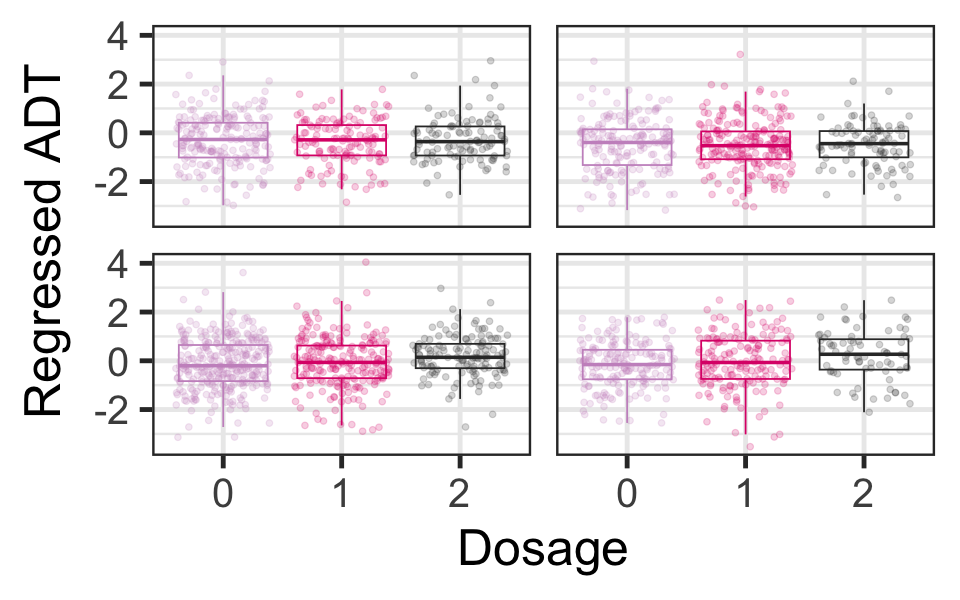

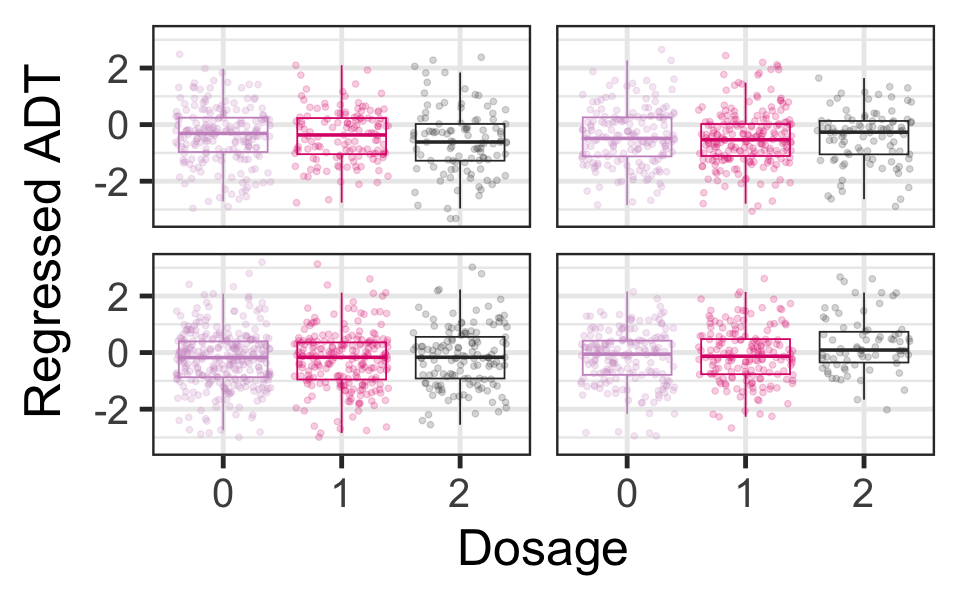

In [540]:
ResidualsPlotADT(full_adt, "CD25")
ResidualsPlotADT(full_exprs, "IL2RA")

# DNA plot

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


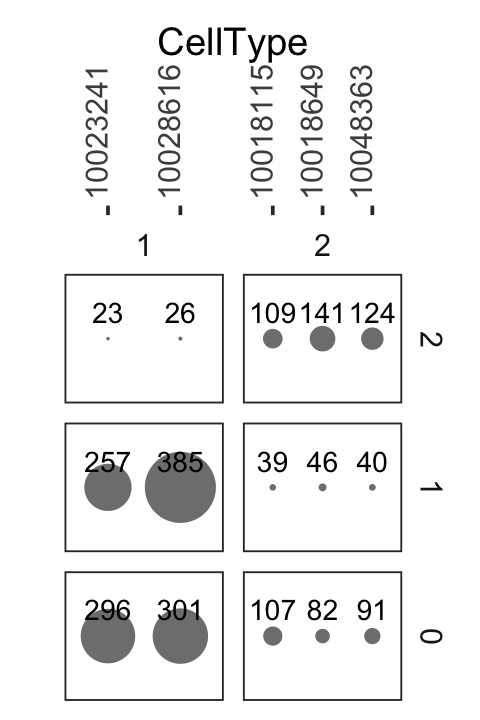

In [519]:
## Plot of IL2RA genotypes distributions across RNA clusters
## Define df for plotting 
test2 <- full_meta %>% add_count(AllelicGenotype,name = "genotype_count") %>% 
    filter(genotype_count  > 10)

#Defineplotting Order
order <- test2$AllelicGenotype %>% table %>% as_data_frame %>% arrange(`n`)
order <- as.character(order$`.`)


fig.size(6,4)
g <- 

table(test2$Dosage,test2$Individual_Index, test2$Run) %>% 
as.data.frame() %>% dplyr::rename(CellType = Var2, genotype = Var1, Run = Var3) %>% 
na.omit %>% filter(Freq != 0) %>% {
    
    ggplot(., aes(CellType,fill=CellType,
                   size = Freq)) +
      geom_point(aes(y = 0),shape = 21, stroke = 0) +
      #geom_hline(yintercept = seq(.5, 4.5, 1), size = .2) +
  scale_x_discrete(position = "top") +
  scale_radius(range = c(1,20)) +
    geom_text(aes(y = 0, label = Freq), size =6, vjust = -0.8)+
  theme_gy() +
  theme(legend.position = "none", 
        panel.grid.major = element_blank(),
        legend.text = element_text(size = 8),
        legend.title = element_text(size = 8), 
       axis.text.x = element_text(angle = 90)) + 
    ylab("") + 
    scale_y_discrete(expand = c(0.1,0.5)) + 
    facet_grid(factor(genotype, levels = c(2,1,0))~ Run, scales="free") + 
    theme(
  strip.background = element_blank(),
  #strip.text.x = element_blank(), 
    #panel.border=element_blank(), 
   # strip.text.y = element_blank()  
        ) +scale_fill_manual(values = c("2"='#8DA0CB',
                                  "1" = '#66C2A5',
                                  "0"='#FC8D62'))
    
} 
plot(g)
suppressWarnings({ 
    ggsave(g, filename = "IL2RA.png", device = "png", dpi = 300, width = 4, height = 6)
    })

# Revisions

In [520]:
# %MT 
pctMito = colSums(full_exprs[rownames(full_exprs)[rownames(full_exprs) %>% startsWith('MT-')], ])

Joining with `by = join_by(cell)`


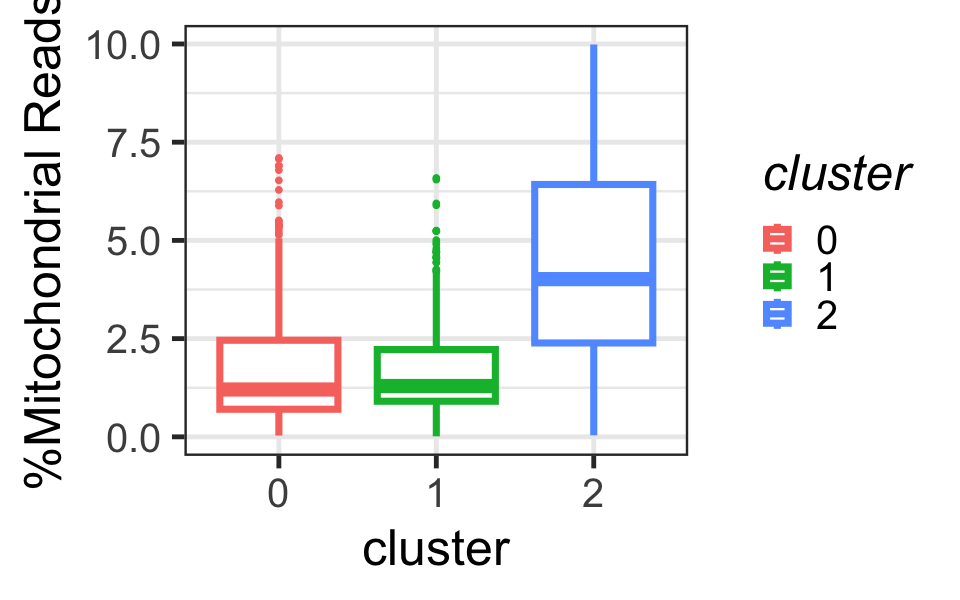

In [529]:
fig.size(5,8)
colSums(full_exprs[rownames(full_exprs)[rownames(full_exprs) %>% startsWith('MT-')], ]) %>% as_tibble(rownames = "cell") %>% 
inner_join(meta_umap.clust) %>% mutate("MITO" = value/nUMI*100) %>% 
ggplot() + 
    geom_boxplot(aes(x= cluster, y = MITO , color = cluster), size = 2)+
    theme_g(30) + theme_gy(30) + theme(legend.position = "right") + ylab("%Mitochondrial Reads")


In [330]:
df <- colSums(full_exprs[rownames(full_exprs)[rownames(full_exprs) %>% startsWith('MT-')], ]) %>% as_tibble(rownames = "cell") %>% 
inner_join(meta_umap.clust) %>% mutate("MITO" = value/nUMI*100) 
    anova(MITO~cluster, data = .)}

Joining with `by = join_by(cell)`


ERROR: Error in UseMethod("anova"): no applicable method for 'anova' applied to an object of class "formula"


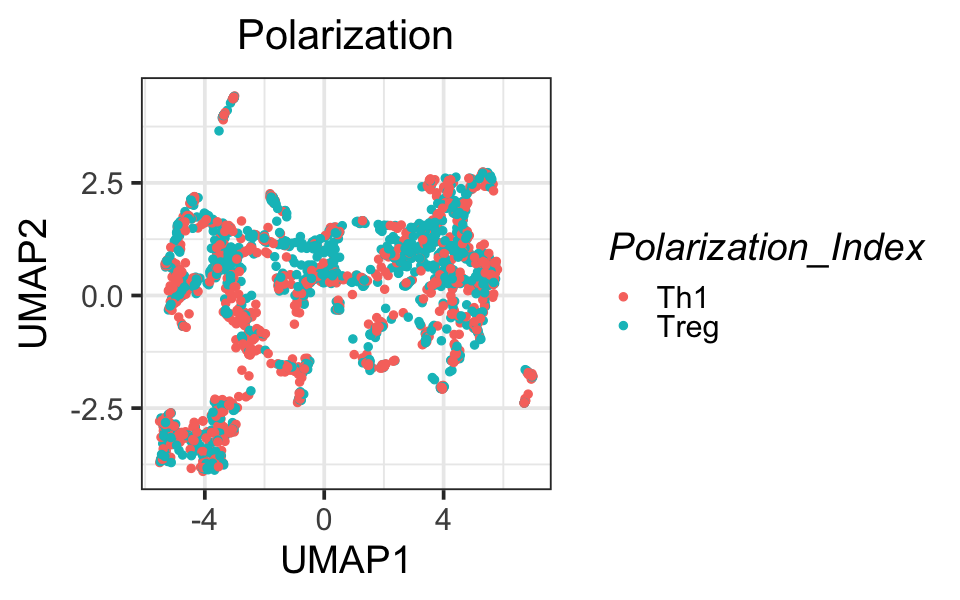

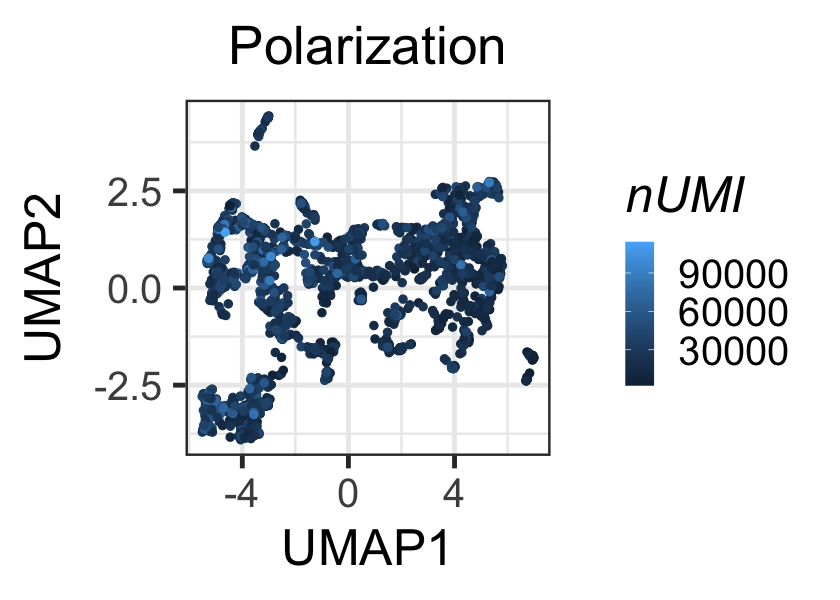

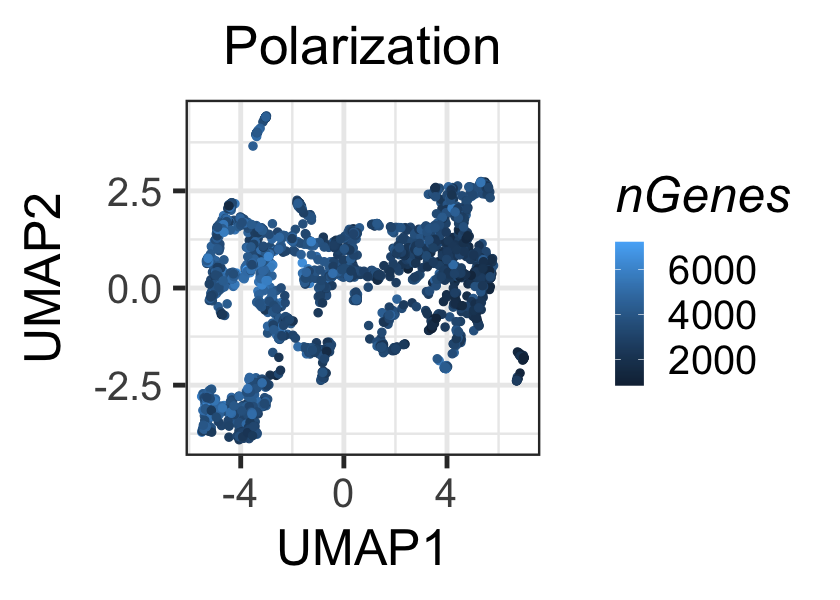

In [526]:
fig.size(5,8)
meta_umap.clust %>% 
ggplot() + 
    geom_point(aes(x= UMAP1, y = UMAP2, col = Polarization_Index), size = 2)+
    theme_g(30) + theme_gy() + theme(legend.position = "right") + ggtitle("Polarization")

fig.size(5,7)
meta_umap.clust %>% 
ggplot() + 
    geom_point(aes(x= UMAP1, y = UMAP2, col = nUMI), size = 2)+
    theme_g(30) + theme_gy(30) + theme(legend.position = "right") + ggtitle("Polarization")

meta_umap.clust %>% 
ggplot() + 
    geom_point(aes(x= UMAP1, y = UMAP2, col = nGenes), size = 2)+
    theme_g(30) + theme_gy(30) + theme(legend.position = "right") + ggtitle("Polarization")


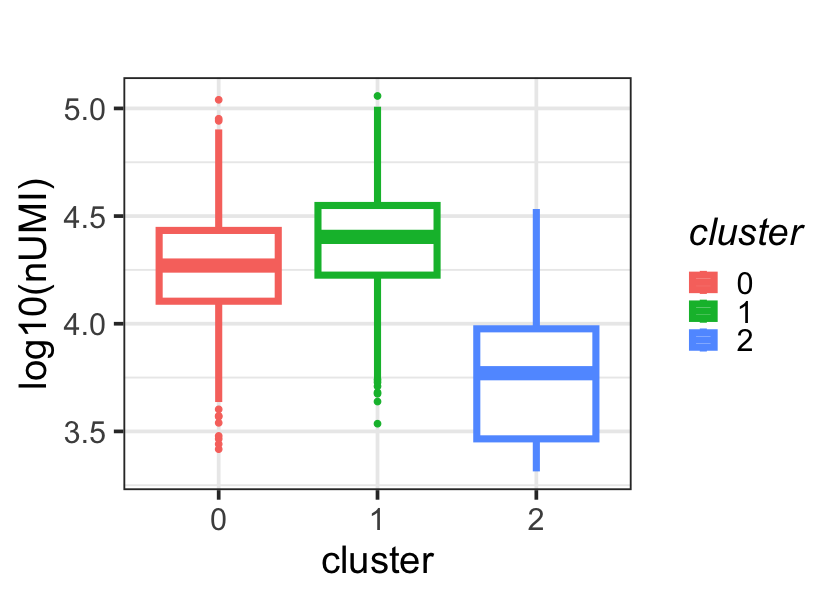

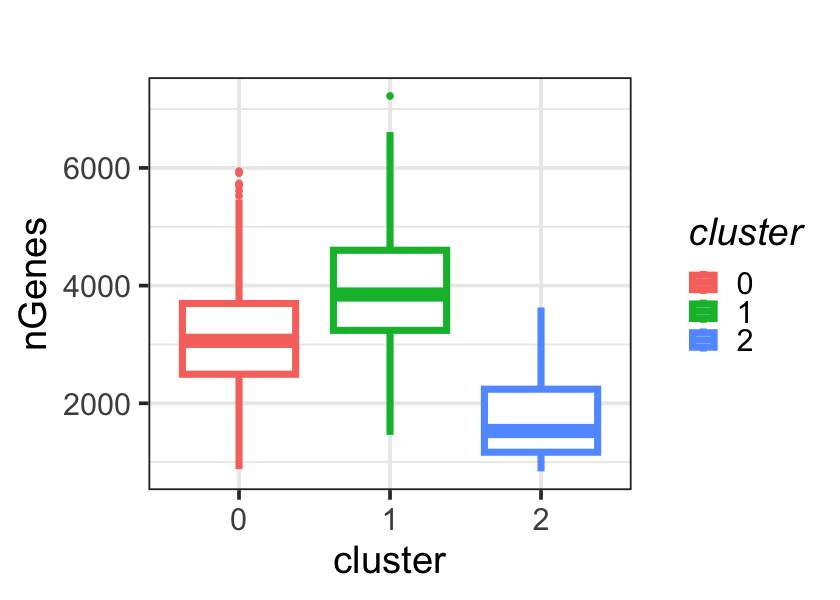

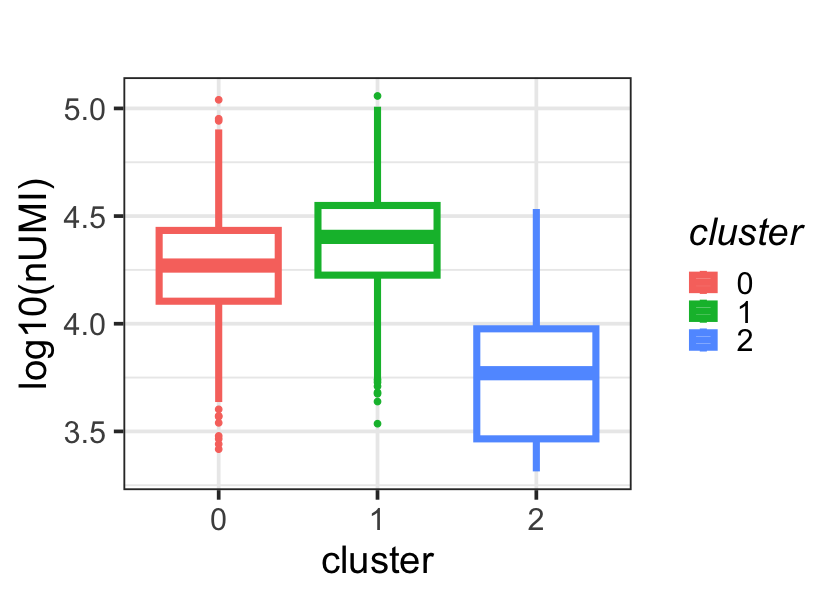

In [527]:
meta_umap.clust %>% 
ggplot() + 
    geom_boxplot(aes(x= cluster, y = log10(nUMI), color = cluster), size = 2)+
    theme_g(30) + theme_gy() + theme(legend.position = "right") + ggtitle("")

meta_umap.clust %>% 
ggplot() + 
    geom_boxplot(aes(x= cluster, y = nGenes, color = cluster), size = 2)+
    theme_g(30) + theme_gy() + theme(legend.position = "right") + ggtitle("")

meta_umap.clust %>% 
ggplot() + 
    geom_boxplot(aes(x= cluster, y = log10(nUMI), color = cluster), size = 2)+
    theme_g(30) + theme_gy() + theme(legend.position = "right") + ggtitle("")


In [ ]:
# Linear Modeling Th1 vs Treg

In [113]:
meta_umap.clust %>% colnames

[1] "cell"               "genotype"           "Dosage"            
 [4] "Run"                "Polarization_Index" "Individual_Index"  
 [7] "nUMI"               "nGenes"             "plate"             
[10] "nUMI_ADT"           "UMAP1"              "UMAP2"             
[13] "PC1"                "PC2"                "PC3"               
[16] "PC4"                "PC5"                "PC6"               
[19] "PC7"                "PC8"                "PC9"               
[22] "PC10"               "res.0.05"           "res.0.1"           
[25] "res.0.15"           "res.0.2"            "res.0.25"          
[28] "res.0.3"            "res.0.35"           "res.0.4"           
[31] "res.0.45"           "res.0.5"            "cluster"

## Polarization Analysis

In [333]:
## Linear modeling with negative binomial or polarization

df <- na.omit(meta_umap.clust)
cells <- df %>% with(cell) 
              
nCells = rowSums(full_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

#Filter on expression in at least 10% of cells
Exprs <- full_exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells]
#Extra filtering step. Mean raw counts of the gene > 1.5 reads per cell - remove noisy low quality counts
#genes <- names(which(rowSums(Exprs)/length(cells)> 2))




suppressWarnings({
Th1_Treg_lm <- 
    sapply(rownames(Exprs), function(i){ 
        
tryCatch({
    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI) + plate + Individual_Index          
                )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI) + plate +Individual_Index+ Polarization_Index
               )
    
    return(c("pval" = anova(lm0,lm1)[2,dim(anova(lm0,lm1))[2]],
             "beta" = summary(lm1)$coeff[dim(summary(lm1)$coeff)[1],1]))
        }, 
        error = function(e) { 
            message("Caught an error for input ", i, "; ", e$message)
            return(c("pval" = NA,
             "beta" = NA))
            }
         )
        })
    })

    
Th1_Treg_lm <- Th1_Treg_lm %>% t %>% as_tibble(rownames = "Genes")
Th1_Treg_lm %>% with(pval) %>% hist
Th1_Treg_lm <- Th1_Treg_lm %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [143]:
Th1_Treg_lm %>% filter(padj < 0.01) %>% filter(Genes %in% c("FOXP3", "SELL", "IL2RA","IRF7","GZMB","HLA-DRB1"))

Genes    pval         beta       padj        
1 IL2RA    3.828049e-13  0.2757030 4.270401e-11
2 IRF7     2.351674e-11 -0.3568119 1.717150e-09
3 HLA-DRB1 1.579309e-06 -0.4787898 4.466554e-05
4 SELL     1.707256e-06  0.3528882 4.794644e-05
5 GZMB     1.915088e-06 -0.4284112 5.304132e-05
6 FOXP3    2.033979e-06  0.5276546 5.556776e-05

In [560]:
ResidualsPlot <- function(data, gene){ 

df <- data[gene, ] %>% as_tibble(rownames = "cell") %>% 
    inner_join(meta_umap.clust, by ="cell") %>% inner_join(
    dplyr::select(full_meta, cell, nUMI)) %>% na.omit()
df$Individual_Index <- as.factor(df$Individual_Index)

#Plotting residuals
#Linear model
ADT_regressed <- glm.nb(data= df, 
   value ~ 1+ Individual_Index + plate + log10(nUMI))

#Pull residuals and add meta data
Residuals_ADT <- resid(ADT_regressed) %>% as_tibble() %>% 
cbind("Dosage" = df$Dosage, 
      "cluster" = df$cluster, 
      "Polarization" = df$Polarization_Index, 
      "Run" = df$Run, 
         "Individual" = df$Individual_Index, 
     "Plate" = df$plate) 

#Plot
g<- Residuals_ADT %>% 
ggplot(aes(as.factor(cluster), value, color = as.factor(cluster))) +

#stat_summary(fun.data = mean_cl_normal, geom = "errorbar") +  
ylab("Regressed ADT") + 
xlab("Dosage") + theme_gy() + 
geom_violin(outlier.shape = NA)+
geom_jitter(alpha = 0.2)+ 
theme(strip.text = element_blank()) + 

theme(legend.position = 'none') + theme_gy(30)

return(
plot(g))
}

Joining with `by = join_by(cell, nUMI)`
Warning message in geom_violin(outlier.shape = NA):
“Ignoring unknown parameters: `outlier.shape`”
Joining with `by = join_by(cell, nUMI)`
Warning message in geom_violin(outlier.shape = NA):
“Ignoring unknown parameters: `outlier.shape`”


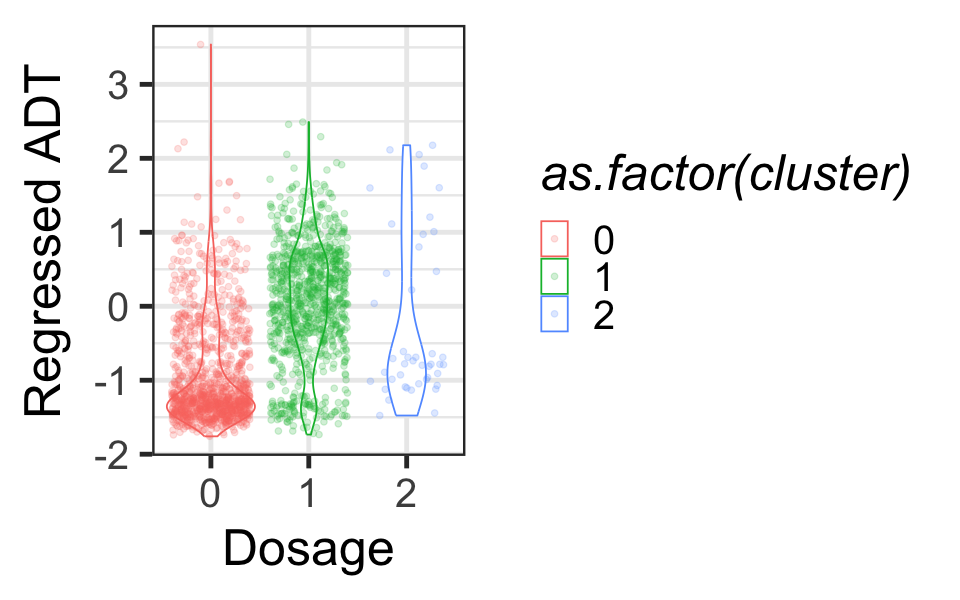

Joining with `by = join_by(cell, nUMI)`
Warning message in geom_violin(outlier.shape = NA):
“Ignoring unknown parameters: `outlier.shape`”


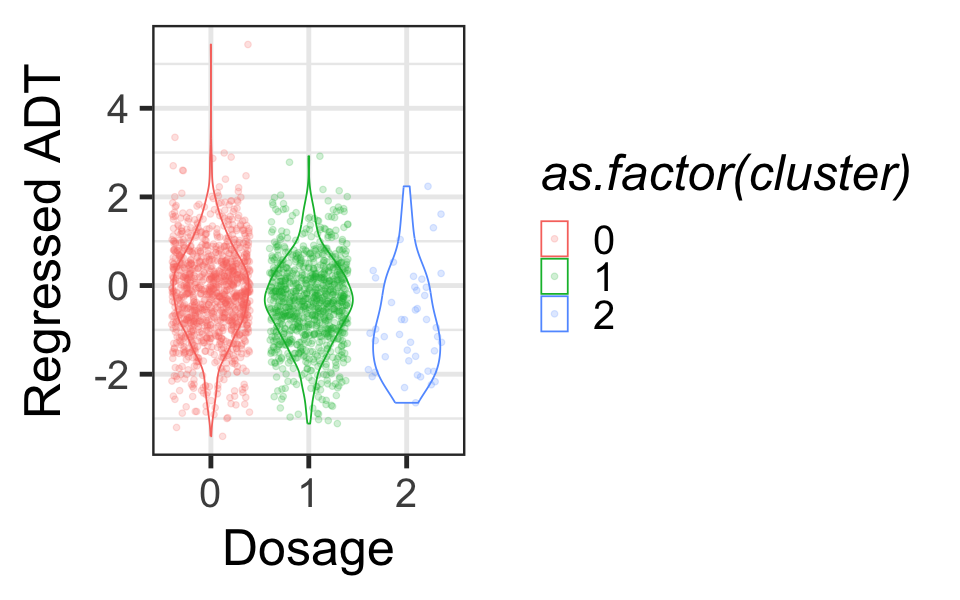

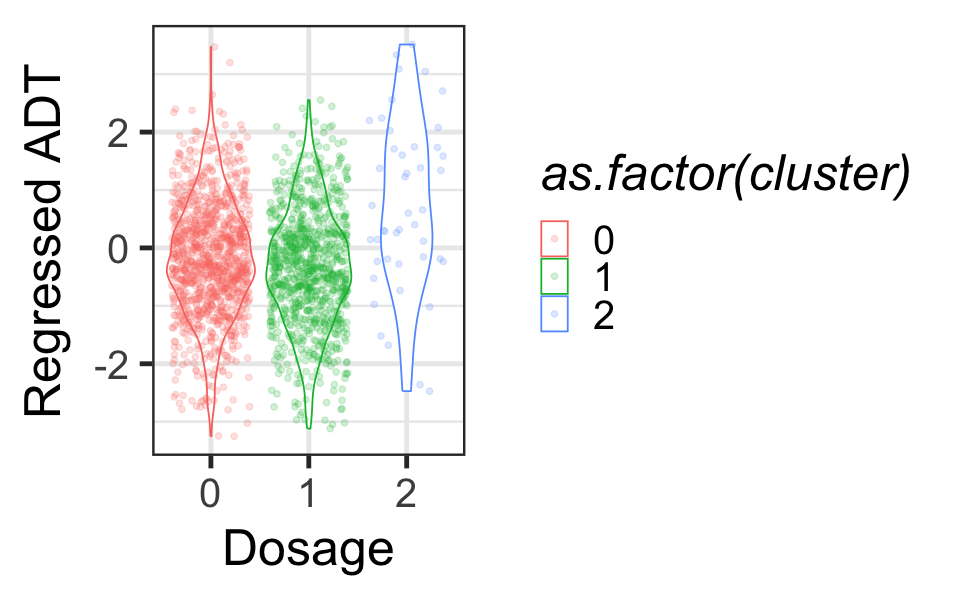

In [561]:
fig.size(5,8)
ResidualsPlot(full_exprs, "MKI67")
ResidualsPlot(full_exprs, "IL2RA")
ResidualsPlot(full_adt, "CD25")

In [558]:
ResidualsPlot <- function(data, gene){ 

df <- data[gene, ] %>% as_tibble(rownames = "cell") %>% 
    inner_join(meta_umap.clust, by ="cell") %>% inner_join(
    dplyr::select(full_meta, cell, nUMI)) %>% na.omit()
df$Individual_Index <- as.factor(df$Individual_Index)

#Plotting residuals
#Linear model
ADT_regressed <- glm.nb(data= df, 
   value ~ 1+ Individual_Index + plate + log10(nUMI))

#Pull residuals and add meta data
Residuals_ADT <- resid(ADT_regressed) %>% as_tibble() %>% 
cbind("Dosage" = df$Dosage, 
      "cluster" = df$cluster, 
      "Polarization" = df$Polarization_Index, 
      "Run" = df$Run, 
         "Individual" = df$Individual_Index, 
     "Plate" = df$plate) 

#Plot
g<- Residuals_ADT %>% 
ggplot(aes(as.factor(Polarization), value, color = as.factor(Polarization))) +

#stat_summary(fun.data = mean_cl_normal, geom = "errorbar") +  
ylab("Regressed ADT") + 
xlab("Dosage") + theme_gy() + 
geom_violin(outlier.shape = NA)+
geom_jitter(alpha = 0.2)+ 
theme(strip.text = element_blank()) + 

theme(legend.position = 'none') + theme_gy()

return(
plot(g))
}

Joining with `by = join_by(cell, nUMI)`
Warning message in geom_violin(outlier.shape = NA):
“Ignoring unknown parameters: `outlier.shape`”
Joining with `by = join_by(cell, nUMI)`
Warning message in geom_violin(outlier.shape = NA):
“Ignoring unknown parameters: `outlier.shape`”


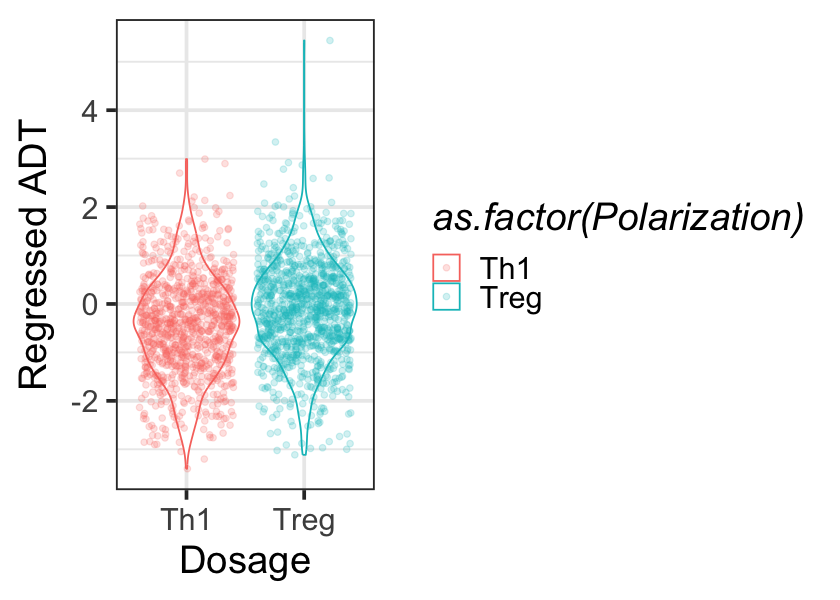

Joining with `by = join_by(cell, nUMI)`
Warning message in geom_violin(outlier.shape = NA):
“Ignoring unknown parameters: `outlier.shape`”


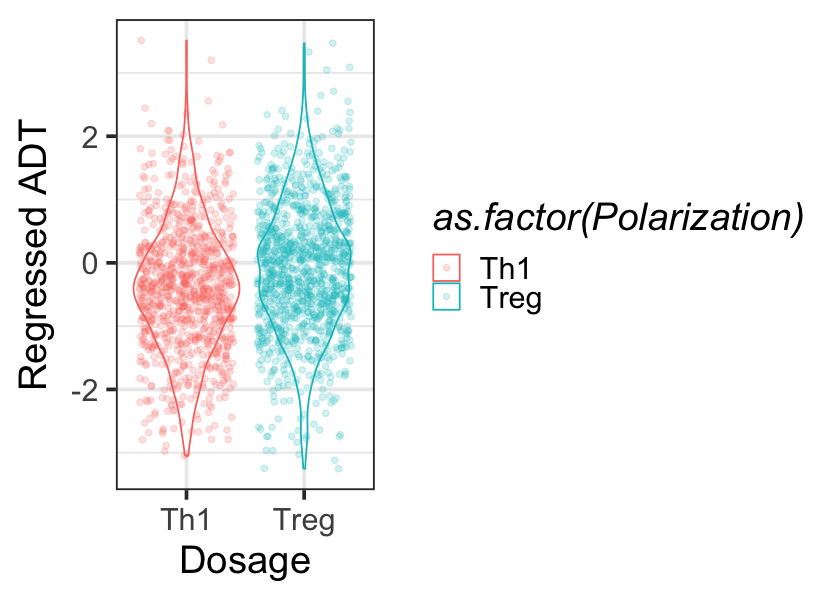

Joining with `by = join_by(cell, nUMI)`
Warning message in geom_violin(outlier.shape = NA):
“Ignoring unknown parameters: `outlier.shape`”


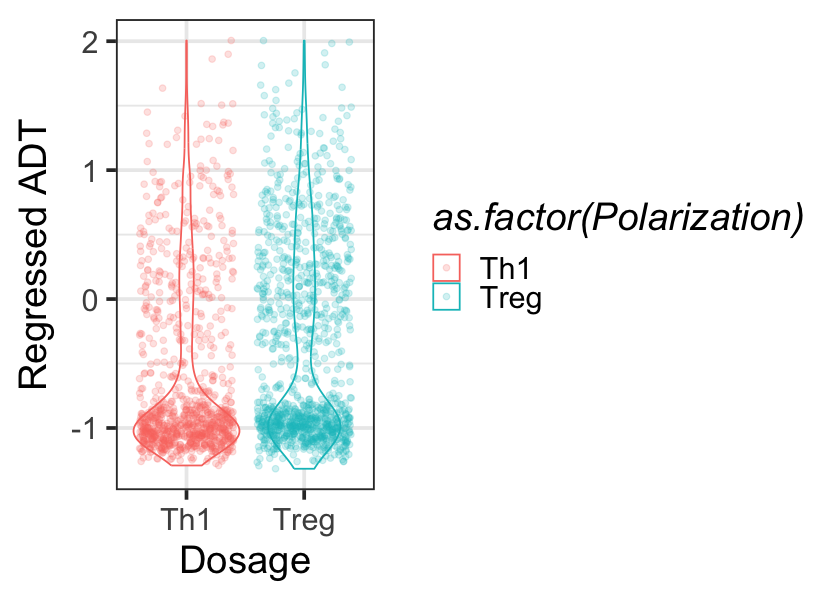

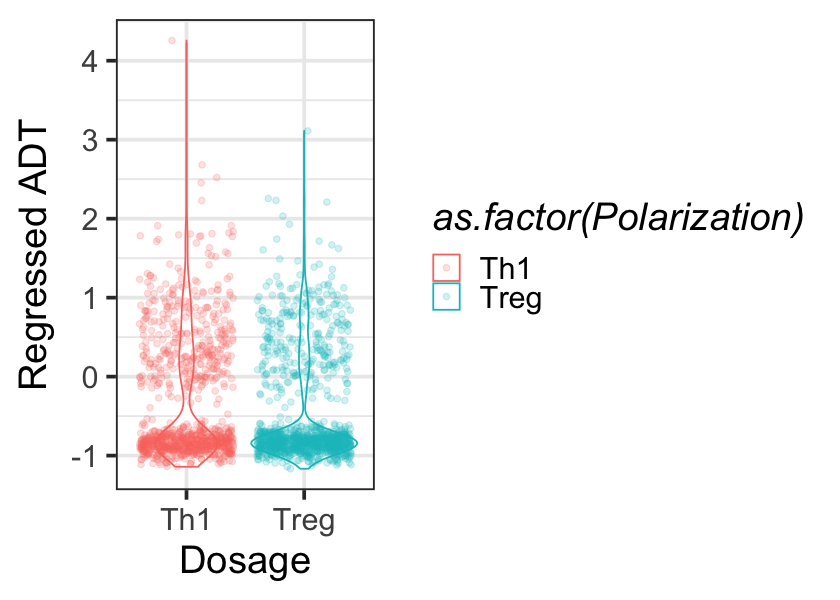

In [559]:
ResidualsPlot(full_exprs, "IL2RA")
ResidualsPlot(full_adt, "CD25")
ResidualsPlot(full_exprs, "FOXP3")
ResidualsPlot(full_exprs, "STAT4")